In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

warnings.filterwarnings("ignore")

sns.set_theme(style="whitegrid", font_scale=0.9)
np.random.seed(0)

### Feature selection methods implementation

In [2]:
# mutual information based methods

from sklearn.metrics import mutual_info_score


def discretize(x, bins=5):
    return pd.qcut(x, q=bins, labels=False, duplicates="drop").astype(int)


def mutual_information(x, y):
    return mutual_info_score(x, y)


def conditional_mutual_information(x, y, z):
    cmi = 0
    for zi in np.unique(z):
        p_z = (z == zi).sum() / z.shape[0]
        cmi += mutual_info_score(x[z == zi], y[z == zi]) * p_z
    return cmi


def joint_mutual_information(X, y, k, S):
    i1 = mutual_info_score(X[:, k], y)
    i2 = 0
    for j in S:
        i2 += mutual_information(X[:, k], X[:, j])
        i2 -= conditional_mutual_information(X[:, k], X[:, j], y)
    return i1 - 1 / len(S) * i2


def conditional_mutual_information_maximization(X, y, k, S):
    i_arr = [conditional_mutual_information(X[:, k], y, X[:, j]) for j in S]
    return np.min(i_arr)


# stopping rule for mutual information based methods
# max. number of features = 2 * sqrt(n_features) + 1
# if value returned by criterion is equal to 0, then stop
# if value returned by criterion is lower than 90% of two last values, then stop
def feature_selection_mi(
    X,
    y,
    criterion,
    bins=5,
    max_features=None,
    stop_threshold=0.9,
):
    X = np.apply_along_axis(discretize, axis=0, arr=X, bins=bins)
    if np.unique(y).shape[0] > 5:
        y = discretize(y, bins=5)
    
    first_feature = np.argmax(
        [mutual_information(X[:, i], y) for i in range(X.shape[1])]
    )
    S = [first_feature]

    if max_features is None:
        max_features = 2 * int(np.sqrt(X.shape[1]) + 1)

    while len(S) < min(X.shape[1], max_features):

        max_mi_list = []
        max_mi = -1
        max_mi_idx = -1

        for i in range(X.shape[1]):
            if i in S:
                continue
            mi = criterion(X, y, i, S)
            if mi > max_mi:
                max_mi = mi
                max_mi_idx = i

        if max_mi == 0:
            break

        if len(max_mi_list) > 1 and max_mi < stop_threshold * np.mean(max_mi_list[-2:]):
            break

        S.append(max_mi_idx)
    return S

In [3]:
def fit_grid_search_rf(X, y):
    return GridSearchCV(
        estimator=RandomForestClassifier(n_estimators=50, random_state=0),
        param_grid={
            "max_depth": [2, 4, 6],
            "min_samples_split": [2, 4, 6],
            "min_samples_leaf": [2, 5, 10],
        },
        scoring="accuracy",
        cv=StratifiedKFold(n_splits=4, shuffle=True, random_state=0),
        n_jobs=-1,
    ).fit(X=X, y=y)

# stopping rule for random forest based method
# max. number of features = 2 * sqrt(n_features) + 1
# min. feature importance = 1 / n_features
def feature_selection_rf(
    X,
    y,
    max_features=None,
):
    grid_search_rf = fit_grid_search_rf(X, y)
    
    feature_importances_ = grid_search_rf.best_estimator_.feature_importances_
    feature_importances_ = pd.Series(
        feature_importances_, name="importance"
    ).sort_values(ascending=False)

    n_features = feature_importances_.shape[0]
    if max_features is None:
        max_features = 2 * int(np.sqrt(X.shape[1]) + 1)
        
    min_feature_importance = 0.5 / n_features
    return (
        feature_importances_[feature_importances_ > min_feature_importance]
        .iloc[:max_features]
        .index.to_list()
    )

In [4]:
# sequential feature selection
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html#sklearn.feature_selection.SequentialFeatureSelector
def feature_selection_sequential(
    X,
    y,
    max_features=None,
):
    n_features = X.shape[1]
    if max_features is None:
        max_features = 2 * int(np.sqrt(n_features) + 1)

    knn = KNeighborsClassifier(n_neighbors=3)
    sfs = SequentialFeatureSelector(
        knn,
        n_features_to_select=max_features,
        direction="forward",
        n_jobs=-1,
        cv=StratifiedKFold(n_splits=4, shuffle=True, random_state=0),
    )
    sfs.fit(X, y)
    return sfs.get_feature_names_out(input_features=range(n_features)).tolist()

### Experiments

In [5]:
def get_mean_cv_knn_accuracy(X, y):
    knn = KNeighborsClassifier(n_neighbors=3)
    cv_results = cross_validate(knn, X, y, cv=StratifiedKFold(n_splits=4, shuffle=True, random_state=0))
    return cv_results["test_score"].mean()


def kuncheva_index(subset1, subset2, n):
    k = max(len(subset1), len(subset2))
    r = len(subset1 & subset2)
    return (r * n - k**2) / (k * (n - k))

#### Artifical datasets

In [6]:
n = 500

# dataset with 5 relevant and 5 irrelevant features
def get_X_y_irrelevant():
    X = scipy.stats.norm.rvs(loc=0, scale=1, size=(n, 10))
    y = discretize(X[:, :5].sum(axis=1), bins=2)
    return X, y

# dataset with correlated features
# we assume that the first feature is relevant and the correlated feature is irrelevant
# the correlation coefficient are: [0.9, 0.8, 0.7, 0.6, 0.5]
def get_X_y_correlated():
    X = np.concatenate([
        scipy.stats.multivariate_normal.rvs(mean=[0, 0], cov=[[1, coef], [coef, 1]], size=n)
        for coef in [0.9, 0.8, 0.7, 0.6, 0.5]
    ], axis=1)
    X = np.concatenate([ X[:, 0::2], X[:, 1::2] ], axis=1)
    y = discretize(X[:, :5].sum(axis=1), bins=2)
    return X, y

# XOR problem + 8 irrelevant features
def get_X_y_xor():
    X = scipy.stats.binom.rvs(1, 0.5, size=(n, 10))
    y = X[:, 0] ^ X[:, 1]
    return X, y


DATASETS = {
    "irrelevant": {
        "func": get_X_y_irrelevant,
        "all_features": list(range(10)),
        "relevant_features": list(range(5)),
    },
    "correlated": {
        "func": get_X_y_correlated,
        "all_features": list(range(10)),
        "relevant_features": list(range(5)),
    },
    "XOR": {
        "func": get_X_y_xor,
        "all_features": list(range(10)),
        "relevant_features": list(range(2)),
    },

}

##### Success Rate ([Bolón-Canedo et. al. 2012](https://link.springer.com/article/10.1007/s10115-012-0487-8))

$$ Suc. = \left[\frac{R_s}{R_t} - \alpha \frac{I_s}{I_t}\right]$$

* $R_s$ - the number of relevant features selected
* $R_t$ - the total number of relevant features
* $I_s$ - the number of irrelevant features selected
* $I_t$ - the total number of irrelevant features
* $\alpha = \{ \frac{1}{2}, \frac{R_t}{I_t} \}$

In [7]:
def success_rate(all_features, selected_features, relevant_features):
    all_features = set(all_features)
    selected_features = set(selected_features)
    relevant_features = set(relevant_features)
    Rs = len(selected_features.intersection(relevant_features))
    Rt = len(relevant_features)
    Is = len(selected_features.difference(relevant_features))
    It = len(all_features.difference(relevant_features))
    alpha = min(0.5, Rt / It)
    return Rs / Rt - alpha * Is / It

In [8]:
# ITERATIONS = 100

# records = []

# for iter in range(ITERATIONS):
#     for dataset_name, dataset in DATASETS.items():
#         X, y = dataset["func"]()
#         all_features = dataset["all_features"]
#         relevant_features = dataset["relevant_features"]
#         max_features = len(relevant_features) + 1

#         selected_features_jmi = feature_selection_mi(X, y, joint_mutual_information, max_features=max_features)
#         selected_features_cmim = feature_selection_mi(X, y, conditional_mutual_information_maximization, max_features=max_features)
#         selected_features_rf = feature_selection_rf(X, y, max_features=max_features)
#         selected_features_sequential = feature_selection_sequential(X, y, max_features=max_features)

#         success_rate_jmi = success_rate(all_features, selected_features_jmi, relevant_features)
#         success_rate_cmim = success_rate(all_features, selected_features_cmim, relevant_features)
#         success_rate_rf = success_rate(all_features, selected_features_rf, relevant_features)
#         success_rate_sequential = success_rate(all_features, selected_features_sequential, relevant_features)

#         all_features_acc = get_mean_cv_knn_accuracy(X, y)
#         selected_features_jmi_acc = get_mean_cv_knn_accuracy(X[:, selected_features_jmi], y)
#         selected_features_cmim_acc = get_mean_cv_knn_accuracy(X[:, selected_features_cmim], y)
#         selected_features_rf_acc = get_mean_cv_knn_accuracy(X[:, selected_features_rf], y)
#         selected_features_sequential_acc = get_mean_cv_knn_accuracy(X[:, selected_features_sequential], y)

#         records.append({"iter": iter, "dataset": dataset_name, "method": "All", "success rate": None, "features": [], "accuracy": all_features_acc})
#         records.append({"iter": iter, "dataset": dataset_name, "method": "JMI", "success rate": success_rate_jmi, "features": selected_features_jmi, "accuracy": selected_features_jmi_acc})
#         records.append({"iter": iter, "dataset": dataset_name, "method": "CMIM", "success rate": success_rate_cmim, "features": selected_features_cmim, "accuracy": selected_features_cmim_acc})
#         records.append({"iter": iter, "dataset": dataset_name, "method": "RF", "success rate": success_rate_rf, "features": selected_features_rf, "accuracy": selected_features_rf_acc})
#         records.append({"iter": iter, "dataset": dataset_name, "method": "Sequential", "success rate": success_rate_sequential, "features": selected_features_sequential, "accuracy": selected_features_sequential_acc})

# pd.DataFrame(records).to_pickle("results_artificial_datasets.pkl")
df = pd.read_pickle("results_artificial_datasets.pkl")

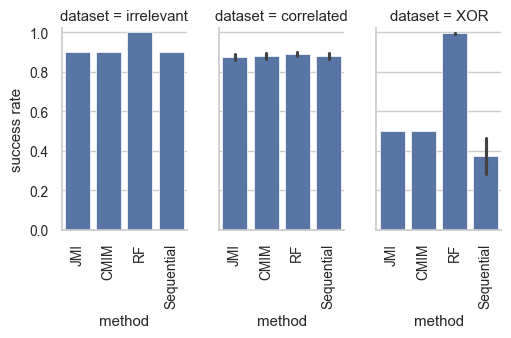

In [9]:
g = sns.FacetGrid(df.loc[df["method"] != "All"], col="dataset", height=3, aspect=0.6, ylim=[0, 1.02])
g.map_dataframe(sns.barplot, x="method", y="success rate", linewidth=0.5)
g.set_xticklabels(rotation=90)
plt.savefig("artificial-data-success-rate.png", dpi=300, bbox_inches="tight")
plt.show()

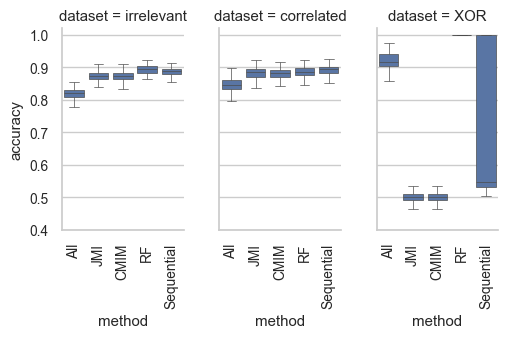

In [10]:
g = sns.FacetGrid(df, col="dataset", height=3, aspect=0.6, ylim=[0.4, 1.02])
g.map_dataframe(sns.boxplot, x="method", y="accuracy", linewidth=0.5, showfliers=False)
g.set_xticklabels(rotation=90)
plt.savefig("artificial-data-acc.png", dpi=300, bbox_inches="tight")
plt.show()

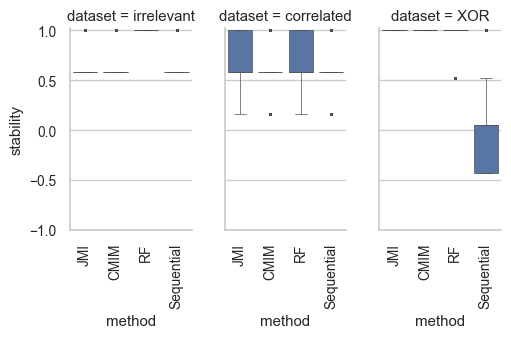

In [11]:
stability_records = []

for dataset_name, dataset in DATASETS.items():
    for method in ["JMI", "CMIM", "RF", "Sequential"]:

        subsets = df.loc[(df["method"] == method) & (df["dataset"] == dataset_name), "features"].to_list()

        for i in range(len(subsets)):
            for j in range(i+1, len(subsets)):
                features1 = set(subsets[i])
                features2 = set(subsets[j])
                k_idx = kuncheva_index(features1, features2, len(dataset["all_features"]))
                stability_records.append({"dataset": dataset_name, "method": method, "stability": k_idx})

stability_df = pd.DataFrame(stability_records)

g = sns.FacetGrid(stability_df, col="dataset", height=3, aspect=0.6, ylim=[-1, 1.02])
g.map_dataframe(sns.boxplot, x="method", y="stability", linewidth=0.5, showfliers=True, fliersize=0.4)
g.set_xticklabels(rotation=90)
plt.savefig("artificial-data-stability.png", dpi=300, bbox_inches="tight")
plt.show()

#### Real-world datasets
* https://archive.ics.uci.edu/dataset/1/abalone
* https://archive.ics.uci.edu/dataset/848/secondary+mushroom+dataset
* https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success

**Remarks:**
* not-so-large datasets (computational reasons)
* abalone - the smallest one
* mushroom - larger number of observations
* students - larger number of features

In [12]:
# abalone
abalone = pd.read_csv("datasets/abalone.csv", header=None)
abalone[0] = OrdinalEncoder().fit_transform(abalone[[0]])
abalone_X = abalone.iloc[:, :-1].to_numpy()
abalone_X = StandardScaler().fit_transform(abalone_X)
abalone_y = abalone.iloc[:, -1].to_numpy()
abalone_y = discretize(abalone_y, bins=2)

print("Abalone:", abalone_X.shape)

# mushroom
mushroom = pd.read_csv("datasets/mushroom.csv", sep=";")
mushroom = mushroom.loc[:, (mushroom.isna().sum() < mushroom.shape[0] * 0.1).loc[lambda x: x].index].dropna()
for col, dtype in zip(mushroom.columns, mushroom.dtypes):
    if dtype == "object":
        mushroom[col] = OrdinalEncoder().fit_transform(mushroom[[col]])

mushroom_X = mushroom.drop(columns="class").to_numpy()
mushroom_X = StandardScaler().fit_transform(mushroom_X)
mushroom_y = mushroom["class"].astype(int).to_numpy()

print("Mushroom:", mushroom_X.shape)

# students
students = pd.read_csv("datasets/students.csv", sep=";")
students["Target"] = OrdinalEncoder().fit_transform(students[["Target"]])

students_X = students.iloc[:, :-1].to_numpy()
students_X = StandardScaler().fit_transform(students_X)
students_y = students.iloc[:, -1].to_numpy()

print("Students:", students_X.shape)

Abalone: (4177, 8)
Mushroom: (58598, 12)
Students: (4424, 36)


In [13]:
DATASETS = [
    ("Abalone", abalone_X, abalone_y),
    ("Mushroom", mushroom_X, mushroom_y),
    ("Students", students_X, students_y),
]

In [14]:
# ITERATIONS = 50

# records = []

# for iter in range(ITERATIONS):
#     for dataset_name, X, y in DATASETS:
#         n = X.shape[0]
#         idx = np.random.choice(n, n, replace=True)
#         Xb = X[idx]
#         yb = y[idx]

#         selected_features_jmi = feature_selection_mi(Xb, yb, joint_mutual_information)
#         selected_features_cmim = feature_selection_mi(Xb, yb, conditional_mutual_information_maximization)
#         selected_features_rf = feature_selection_rf(Xb, yb)
#         selected_features_sequential = feature_selection_sequential(Xb, yb)

#         all_features_acc = get_mean_cv_knn_accuracy(Xb, yb)
#         selected_features_jmi_acc = get_mean_cv_knn_accuracy(Xb[:, selected_features_jmi], yb)
#         selected_features_cmim_acc = get_mean_cv_knn_accuracy(Xb[:, selected_features_cmim], yb)
#         selected_features_rf_acc = get_mean_cv_knn_accuracy(Xb[:, selected_features_rf], yb)
#         selected_features_sequential_acc = get_mean_cv_knn_accuracy(Xb[:, selected_features_sequential], yb)

#         records.append({"iter": iter, "dataset": dataset_name, "method": "All", "accuracy": all_features_acc, "features": list(range(n))})
#         records.append({"iter": iter, "dataset": dataset_name, "method": "JMI", "accuracy": selected_features_jmi_acc, "features": selected_features_jmi})
#         records.append({"iter": iter, "dataset": dataset_name, "method": "CMIM", "accuracy": selected_features_cmim_acc, "features": selected_features_cmim})
#         records.append({"iter": iter, "dataset": dataset_name, "method": "RF", "accuracy": selected_features_rf_acc, "features": selected_features_rf})
#         records.append({"iter": iter, "dataset": dataset_name, "method": "Sequential", "accuracy": selected_features_sequential_acc, "features": selected_features_sequential})

# pd.DataFrame(records).reset_index(drop=True).to_pickle("results_real_world_datasets.pkl")
df = pd.read_pickle("results_real_world_datasets.pkl")
df

,iter,dataset,method,accuracy,features
0,0,Abalone,All,0.811829,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1,0,Abalone,JMI,0.817333,"[7, 5, 4, 3, 2, 6]"
2,0,Abalone,CMIM,0.807043,"[7, 5, 1, 2, 3, 0]"
3,0,Abalone,RF,0.817333,"[7, 3, 4, 6, 2, 5]"
4,0,Abalone,Sequential,0.815659,"[0, 1, 4, 5, 6, 7]"
...,...,...,...,...,...
745,49,Students,All,0.755425,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
746,49,Students,JMI,0.751808,"[30, 24, 29, 25, 31, 23, 19, 22, 3, 28, 1, 6, ..."
747,49,Students,CMIM,0.761980,"[30, 24, 23, 29, 19, 31, 25, 3, 28, 1, 22, 12,..."
748,49,Students,RF,0.788201,"[30, 24, 31, 25, 16, 23, 29, 28, 19, 3, 22, 18]"


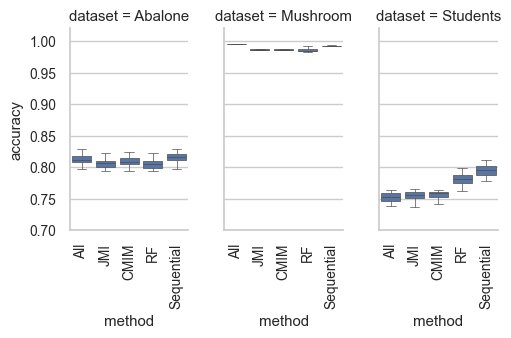

In [15]:
g = sns.FacetGrid(df, col="dataset", height=3, aspect=0.6, ylim=[0.7, 1.02])
g.map_dataframe(sns.boxplot, x="method", y="accuracy", linewidth=0.5, showfliers=False)
g.set_xticklabels(rotation=90)
plt.savefig("real-world-data-acc.png", dpi=300, bbox_inches="tight")
plt.show()

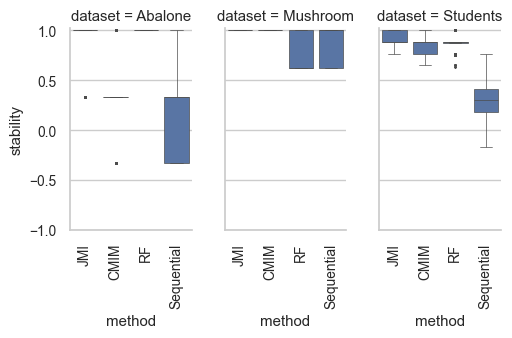

In [16]:
stability_records = []


def kuncheva_index(subset1, subset2, n):
    k = max(len(subset1), len(subset2))
    r = len(subset1 & subset2)
    return (r * n - k**2) / (k * (n - k))


for dataset_name, X, y in DATASETS:
    for method in ["JMI", "CMIM", "RF", "Sequential"]:

        subsets = df.loc[(df["method"] == method) & (df["dataset"] == dataset_name), "features"].to_list()

        for i in range(len(subsets)):
            for j in range(i+1, len(subsets)):
                features1 = set(subsets[i])
                features2 = set(subsets[j])
                k_idx = kuncheva_index(features1, features2, X.shape[1])
                stability_records.append({"dataset": dataset_name, "method": method, "stability": k_idx})

stability_df = pd.DataFrame(stability_records)

g = sns.FacetGrid(stability_df, col="dataset", height=3, aspect=0.6, ylim=[-1, 1.02])
g.map_dataframe(sns.boxplot, x="method", y="stability", linewidth=0.5, showfliers=True, fliersize=0.4)
g.set_xticklabels(rotation=90)
plt.savefig("real-world-data-stability.png", dpi=300, bbox_inches="tight")
plt.show()